# Coincidence Analysis

In [1]:
import numpy as np # math/general purpose
import matplotlib.pyplot as plt # plotting
import os # file/directory access
from tqdm import tqdm # progress bar
from itertools import groupby

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 18

In [2]:
labels = ['trig','SiPM 1','SiPM 2','PMT']
itrig = 0
isipm1 = 1
isipm2 = 2
ipmt = 3

In [3]:
def parseData(data):
    for pulse in data:
        pulse[ipmt] = [-i for i in pulse[ipmt]]
    return data

# smooth out noise of pulse
def smoothpulse(pulse):
    pulse_smooth = []
    radius = 4
    for i in range(len(pulse)):
        if i < radius or i > (len(pulse) - radius):
            pulse_smooth.append(pulse[i])
            continue
        ave = pulse[i]
        for n in range(radius):
            ave += pulse[i-n] + pulse[i+n]
        ave = ave / (radius*2 + 1)
        pulse_smooth.append(ave)
    return np.array(pulse_smooth)

# For pulses to be "coincident", they should be < 100 ns apart
# To trigger, need to be over threshold for > 20ns
def findpulse(pulse, Vpmt):
    # initiate
    t0 = -400
    dt = 0.8 # ns

    trigpulse = np.array(pulse[itrig])
    pmtpulse = np.array(pulse[ipmt])
    
    # check for pmt trigger
    pmt_dgt = pmtpulse > Vpmt
    if np.count_nonzero(pmt_dgt) == 0:
        pmtstart = None
    else:
        pmtstart = t0 + np.argmax(pmtpulse)*dt

    # check for sipm trigger
    sipm_dgt = trigpulse > 1

    # more than 20ns of consecutive signal
    Nt_signal = int(20/dt)
    signal = [(k, sum(1 for i in g)) for k,g in groupby(sipm_dgt)] # count consecutive duplicate items
    sipmstart, indexsum = None, 0
    for (k,g) in signal:
        if k == True and g >= Nt_signal:
            sipmstart = t0 + indexsum*dt
        else:
            indexsum += g

    return (pmtstart, sipmstart)

def findcoincidence(data, PMTVthres, rate):
    # initiate
    coincidence = 0
    pulseheights = []

    # find and print
    for pulse in data:
        pmtpulse, sipmpulse = findpulse(pulse, PMTVthres)
        if pmtpulse and sipmpulse and abs(pmtpulse-sipmpulse) < 100:
            coincidence += 1
            pulseheights.append([max(pulse[i]) for i in range(4)])
    pmtpulseheights = np.array([p[ipmt] for p in pulseheights])

    Ntotal = len(data)
    coincrate = coincidence/Ntotal
    highErate = len(pmtpulseheights[pmtpulseheights>=1.5/4.4])/Ntotal

    print(f'Overall Rate: {rate} Hz')
    print(f'Coincidence rate: {coincrate*100}% ({coincrate*rate} Hz)')
    print(f'Coincidence rate (high E beta): {highErate*100}% ({highErate*rate} Hz)')

    allpmtpulseheights = [max(pulse[ipmt]) for pulse in data]
    return allpmtpulseheights, pulseheights, pmtpulseheights

def plotcoincidence(allpmtpulseheights, pulseheights, pmtpulseheights, title, filename):
    # plot
    bins = np.arange(0, 0.72, 0.02)
    fig, ax = plt.subplots()
    plt.xlim(0,0.7)
    plt.hist(allpmtpulseheights, histtype='step', bins=bins, label="All events", density=True)
    plt.hist(pmtpulseheights, histtype='step', bins=bins, label="Coincident events", density=True)
    plt.xlabel('pulse heights (V)')
    plt.title(f'Pulse heights, {title}')
    plt.legend()
    plt.tight_layout()
    
    fig.savefig(f'./fig2/{filename}_comparison.png')
    
    # plot
    fig, ax = plt.subplots()
    plt.xlim(0,0.7)
    for i in range(1,4):
        plt.hist([p[i] for p in pulseheights], histtype='step', bins=bins, label=labels[i])
    plt.xlabel('pulse heights (V)')
    plt.title(f'Coincident pulse heights, {title}')
    plt.legend()
    plt.tight_layout()
    
    fig.savefig(f'./fig2/{filename}_coincidence.png')

    # Just PMT pulses
    fig, ax = plt.subplots()
    plt.hist(pmtpulseheights, histtype='step', bins=bins)
    plt.xlim(0,0.7)
    ax.set_xlabel('pulse heights (V)')
    plt.title(f'Coincident PMT pulse heights, {title}')
    ax.axvline(1.5/4.4, linestyle=":")

    # make second axis
    ax2 = ax.twiny()
    fig.subplots_adjust(bottom=0.2)
    tick_loc = np.array([1.5, 2, 2.5, 3])
    
    def tick_function(V): return V/4.4/0.7
    
    # Move twinned axis ticks and label from top to bottom
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    
    # Offset the twin axis below the host
    ax2.spines["bottom"].set_position(("axes", -0.15))
    
    # Turn on the frame for the twin axis, but then hide all 
    # but the bottom spine
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)

    for sp in ax2.spines.values():
        sp.set_visible(False)
    ax2.spines["bottom"].set_visible(True)
    
    ax2.set_xticks(tick_function(tick_loc))
    ax2.set_xticklabels(["%.1f"%z for z in tick_loc])
    ax2.set_xlabel("e- energy (MeV)")

    plt.tight_layout()
    fig.savefig(f'./fig2/{filename}_coincidence_PMTpulse.png')

    return

def analysis(title, PMTVthres, rate, files, plot=True):
    # load data
    data = np.load(files[0])
    for f in files[1:]:
        data = np.concatenate((data, np.load(f)))

    filename = files[0].split('/')[-1].replace('.npy','')
    print(f'*** Finding coincidence for {title}... ***')
    allpmtpulseheights, pulseheights, pmtpulseheights = findcoincidence(parseData(data), PMTVthres, rate)
    if plot:
        plotcoincidence(allpmtpulseheights, pulseheights, pmtpulseheights, title, filename)
    print(f'- - - - -')

In [31]:
analysis("Sr-90, Vthres=16mV, SiPM HV=31.9",0.04,24.3,["./data/24-05-10_run-000_Sr90_Vthres-16mV_Ntrace-10000.npy"], False)
analysis("Ru-106, Vthres=16mV, SiPM HV=31.9",0.04,33.7,["./data/24-05-10_run-003_Ru106_Vthres-16mV_Ntrace-10000.npy"], False)

analysis("Ru-106, Vthres=21mV, SiPM HV=31.9",0.04,33.7,["./data/24-05-10_run-005_Ru106_Vthres-21mV_Ntrace-10000.npy"], False)
analysis("Ru-106, Vthres=21mV, SiPM HV=32.9",0.04,33.7,["./data/24-05-10_run-006_Ru106_Vthres-21mV_Ntrace-10000.npy"], False)
analysis("Ru-106, Vthres=21mV, SiPM HV=30.9",0.04,33.7,["./data/24-05-10_run-007_Ru106_Vthres-21mV_Ntrace-10000.npy"], False)
analysis("Ru-106, Vthres=21mV, SiPM HV=33.9",0.04,33.7,["./data/24-05-10_run-008_Ru106_Vthres-21mV_Ntrace-10000.npy"], False)
analysis("Ru-106, Vthres=21mV, SiPM HV=33.4",0.04,33.7,["./data/24-05-11_run-000_Ru106_Vthres-21mV_Ntrace-10000.npy"], False)

analysis("Sr-90, Vthres=21mV, SiPM HV=30.9",0.04,24.3,["./data/24-05-11_run-001_Sr90_Vthres-21mV_Ntrace-10000.npy"], False)
analysis("Sr-90, Vthres=21mV, SiPM HV=31.9",0.04,24.3,["./data/24-05-11_run-003_Sr90_Vthres-21mV_Ntrace-10000.npy"], False)
analysis("Sr-90, Vthres=21mV, SiPM HV=32.9",0.04,24.3,["./data/24-05-11_run-004_Sr90_Vthres-21mV_Ntrace-10000.npy"], False)
analysis("Sr-90, Vthres=21mV, SiPM HV=33.4",0.04,24.3,["./data/24-05-11_run-005_Sr90_Vthres-21mV_Ntrace-10000.npy"], False)
analysis("Sr-90, Vthres=21mV, SiPM HV=33.9",0.04,24.3,["./data/24-05-11_run-006_Sr90_Vthres-21mV_Ntrace-10000.npy"], False)

analysis("Sr-90, Vthres=10mV, SiPM HV=31.9",0.04,24.3,["./data/24-05-13_run-000_Sr90_Vthres-10mV_Ntrace-10000.npy"], False)
analysis("Sr-90, Vthres=10mV, SiPM HV=30.9",0.04,24.3,["./data/24-05-13_run-001_Sr90_Vthres-10mV_Ntrace-10000.npy"], False)
analysis("Sr-90, Vthres=10mV, SiPM HV=32.15",0.04,24.3,["./data/24-05-13_run-008_Sr90_Vthres-10mV_Ntrace-5000.npy"], False)
analysis("Sr-90, Vthres=10mV, SiPM HV=32.4",0.04,24.3,["./data/24-05-13_run-009_Sr90_Vthres-10mV_Ntrace-5000.npy"], False)

analysis("Ru-106, Vthres=10mV, SiPM HV=31.9",0.04,33.7,["./data/24-05-13_run-003_Ru106_Vthres-10mV_Ntrace-10000.npy"], False)
analysis("Ru-106, Vthres=10mV, SiPM HV=30.9",0.04,33.7,["./data/24-05-13_run-004_Ru106_Vthres-10mV_Ntrace-10000.npy"], False)
analysis("Ru-106, Vthres=10mV, SiPM HV=31.4",0.04,33.7,["./data/24-05-13_run-005_Ru106_Vthres-10mV_Ntrace-10000.npy"], False)
analysis("Ru-106, Vthres=10mV, SiPM HV=32.4",0.04,33.7,["./data/24-05-13_run-006_Ru106_Vthres-10mV_Ntrace-5000.npy"], False)
analysis("Ru-106, Vthres=10mV, SiPM HV=30.4",0.04,33.7,["./data/24-05-13_run-007_Ru106_Vthres-10mV_Ntrace-5000.npy"], False)

*** Finding coincidence for Sr-90, Vthres=16mV, SiPM HV=31.9... ***
Overall Rate: 24.3 Hz
Coincidence rate: 39.43039528602995% (9.581586054505278 Hz)
Coincidence rate (high E beta): 1.0680088386938373% (0.2595261478026025 Hz)
- - - - -
*** Finding coincidence for Ru-106, Vthres=16mV, SiPM HV=31.9... ***
Overall Rate: 33.7 Hz
Coincidence rate: 31.25% (10.53125 Hz)
Coincidence rate (high E beta): 6.92% (2.33204 Hz)
- - - - -
*** Finding coincidence for Ru-106, Vthres=21mV, SiPM HV=31.9... ***
Overall Rate: 33.7 Hz
Coincidence rate: 19.96% (6.726520000000001 Hz)
Coincidence rate (high E beta): 4.390000000000001% (1.4794300000000002 Hz)
- - - - -
*** Finding coincidence for Ru-106, Vthres=21mV, SiPM HV=32.9... ***
Overall Rate: 33.7 Hz
Coincidence rate: 38.279999999999994% (12.900360000000001 Hz)
Coincidence rate (high E beta): 8.15% (2.7465500000000005 Hz)
- - - - -
*** Finding coincidence for Ru-106, Vthres=21mV, SiPM HV=30.9... ***
Overall Rate: 33.7 Hz
Coincidence rate: 5.17% (1.742290

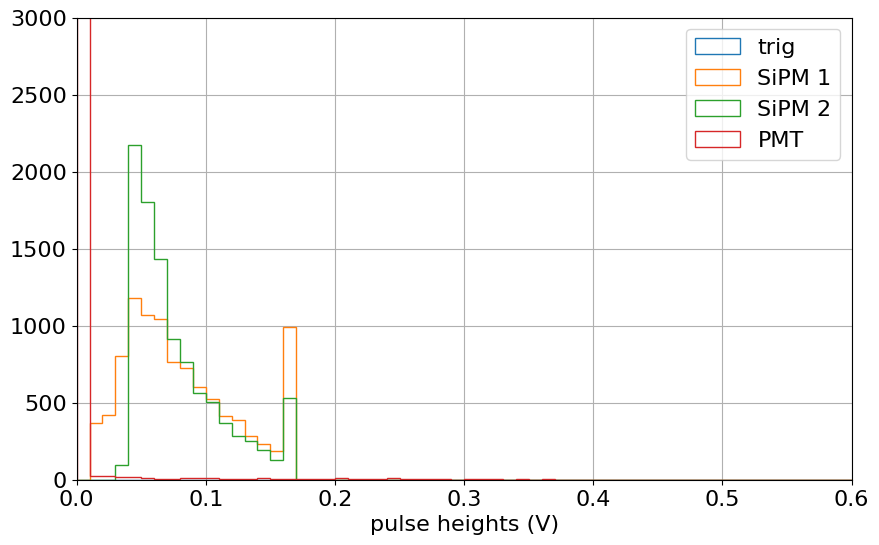

In [62]:
filepath = "./data/24-05-05_run-011_Sr90_Vthres-32mV_Ntrace-10000.npy"
data = parseData(np.load(filepath))
plotdata = []
for i in range(0,4):
    plotdata.append([np.max(d[i]) for d in data])
plt.figure()
for i in range(0,4):
    plt.hist(plotdata[i], histtype='step', bins=np.arange(0,0.7,0.01), label=labels[i])
plt.xlabel('pulse heights (V)')
plt.grid()
plt.xlim(0,0.6)
plt.ylim(0,3000)
plt.legend()
plt.show()

[4429 5157 5881 2828 3208 5281 4804 3470 6594 5795]


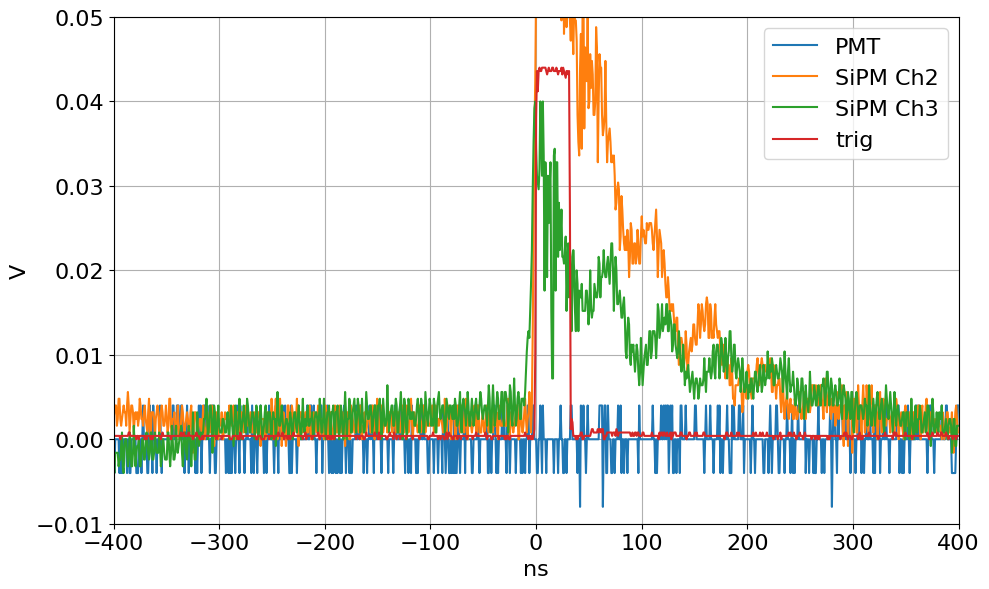

None 0.0


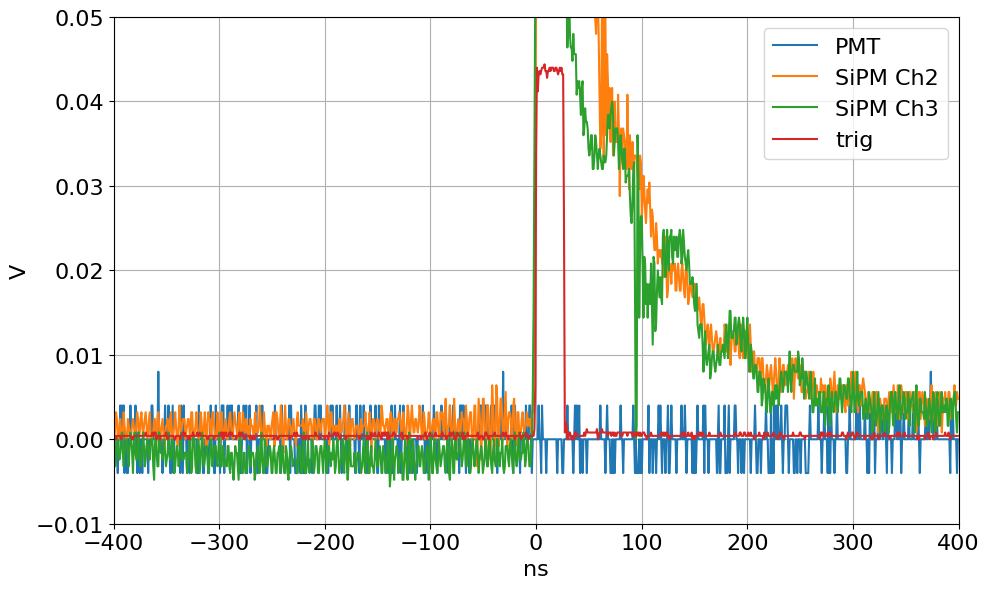

None 0.0


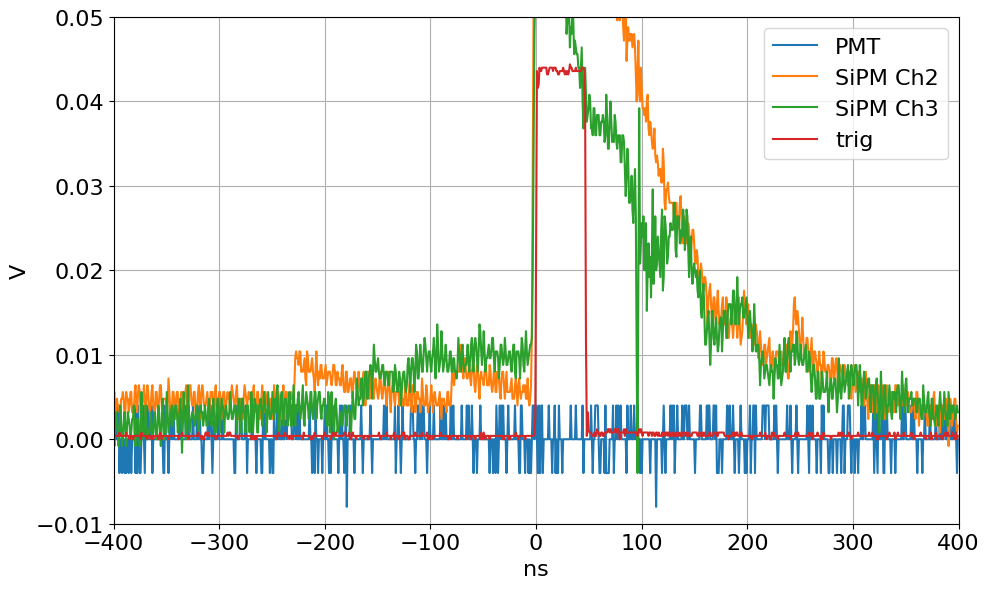

None 0.0


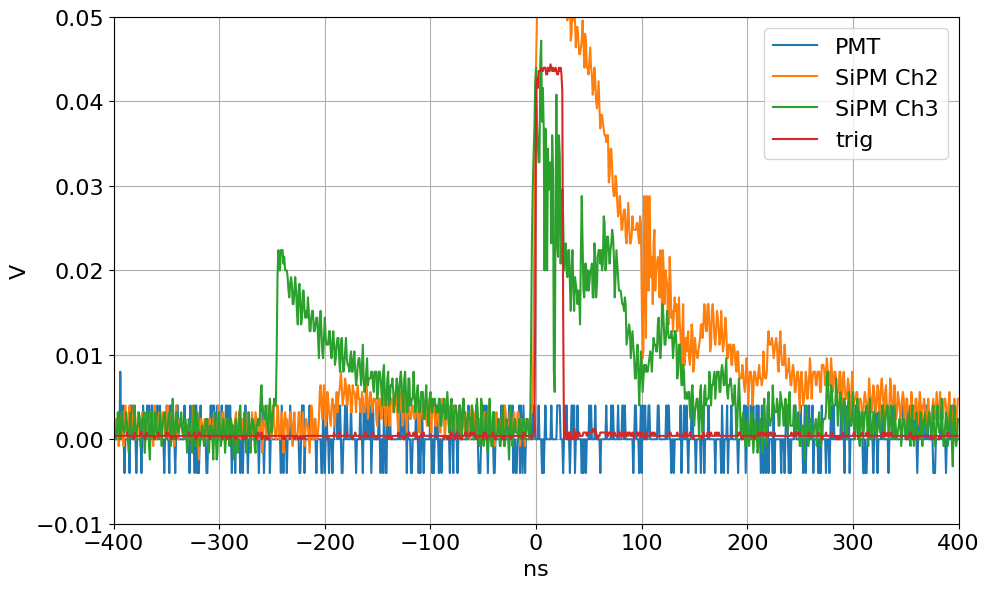

None -0.7999999999999545


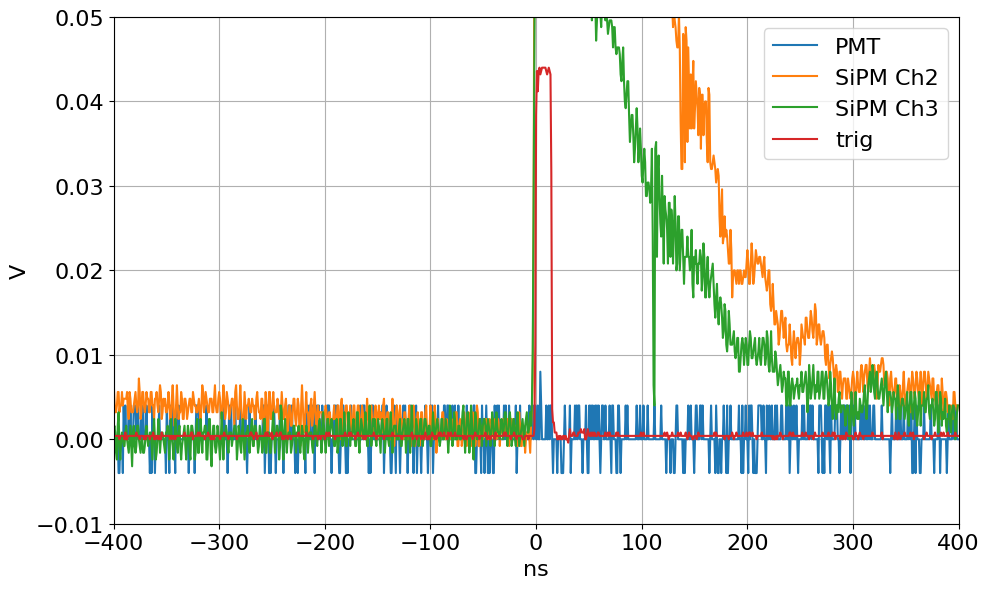

None None


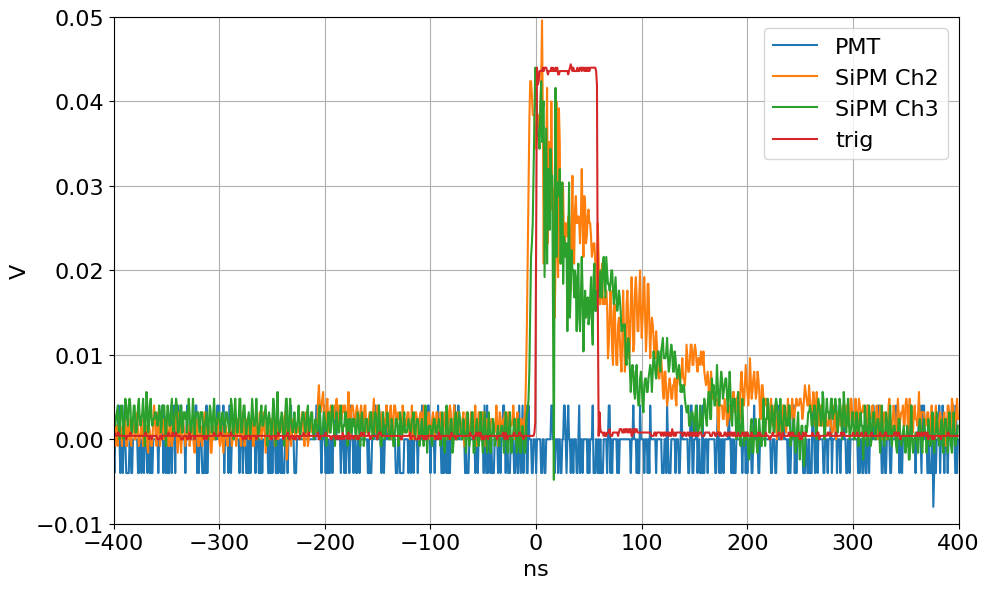

None 0.0


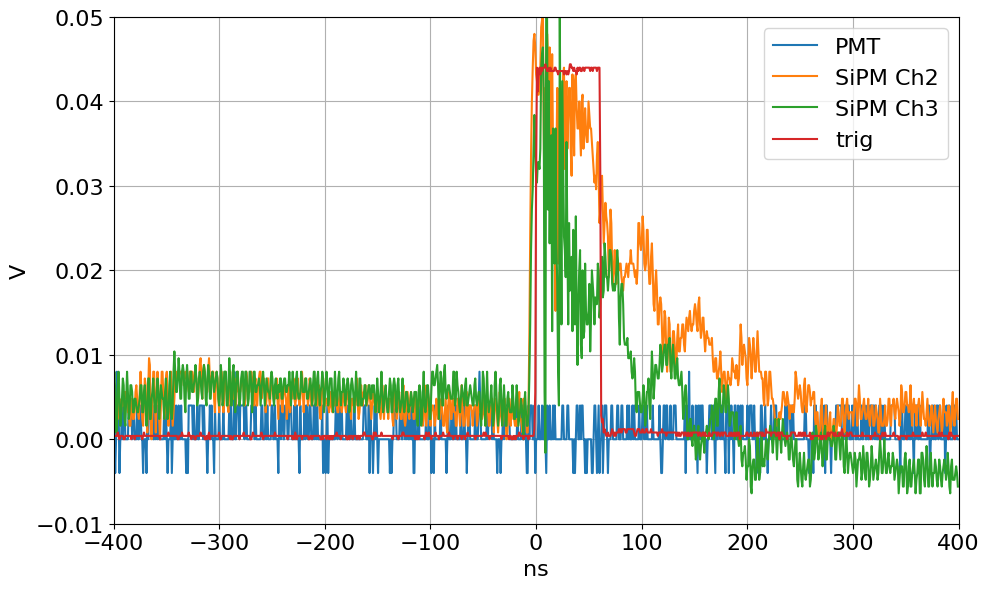

None 0.0


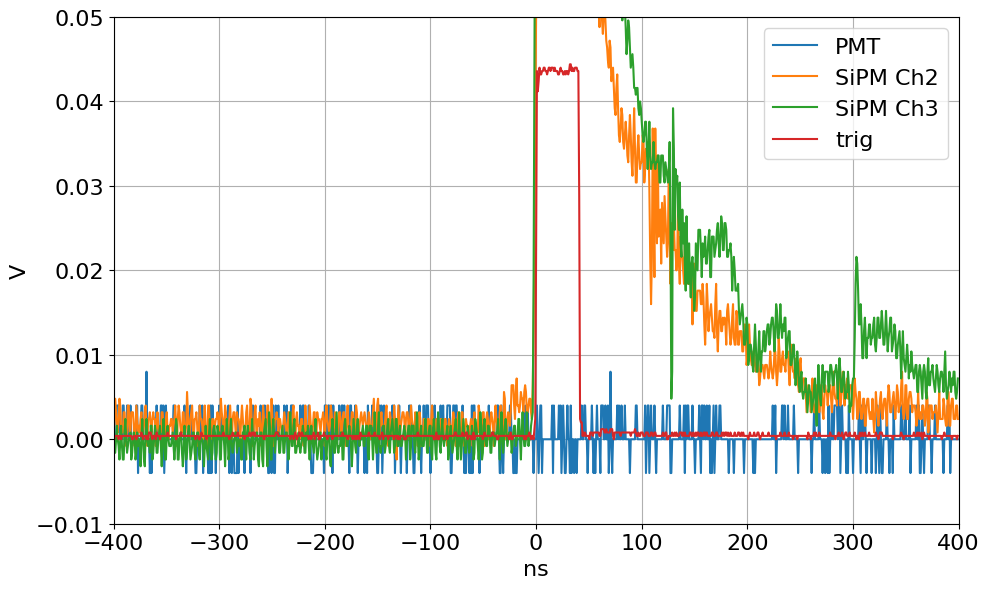

None 0.0


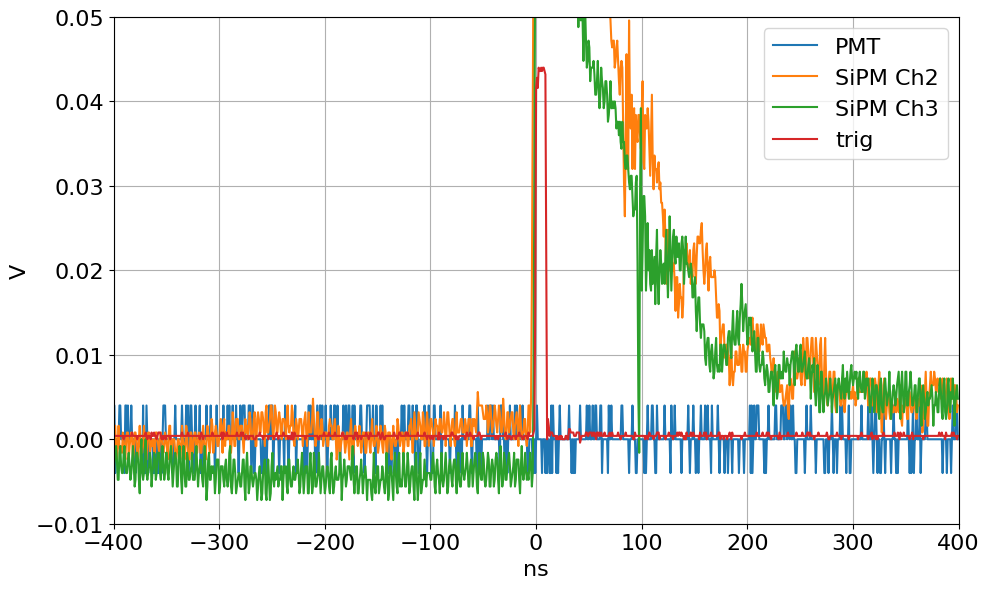

None None


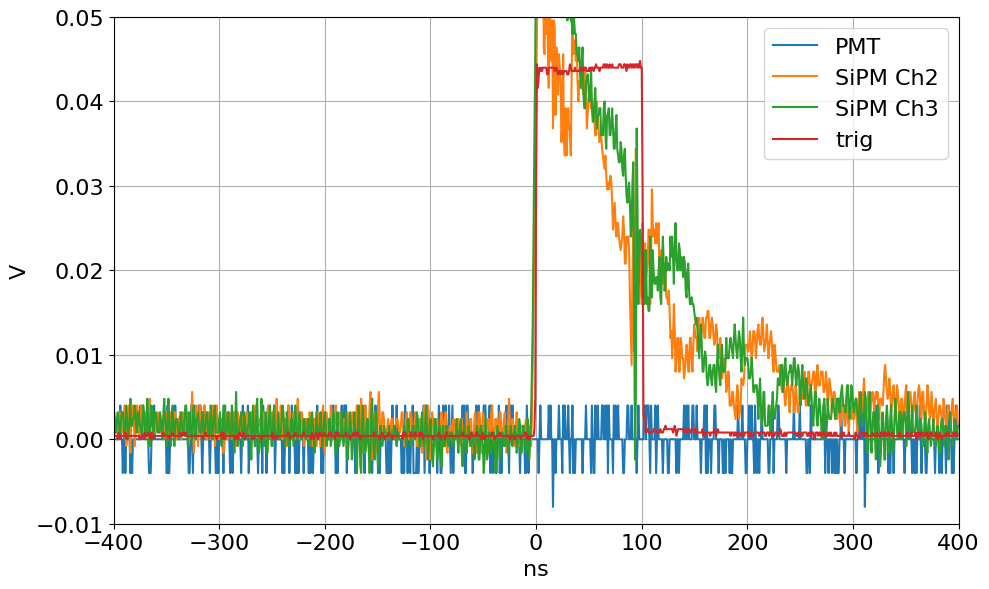

None 0.0


In [83]:
filepath = "./data/24-05-05_run-010_Sr90_Vthres-32mV_Ntrace-10000.npy"
data = parseData(np.load(filepath))
x_zero = -400
x_inc = 0.8
time = np.array([(x_zero +  t*x_inc) for t in range(1000)])

selected = np.random.choice(len(data), 10, replace=False)
print(selected)
#selected = [301]
for pulse in np.array(data)[selected]:
#for pulse in data:
    pmtpulse, sipmpulse = findpulse(pulse, 0.04)
    plt.figure()
    plt.plot(time, pulse[3], label="PMT")
    plt.plot(time, pulse[1], label="SiPM Ch2")
    plt.plot(time, pulse[2], label="SiPM Ch3")
    plt.plot(time, pulse[0]/100, label="trig")
    plt.xlim(-400,400)
    plt.xlabel('ns')
    plt.ylim(-0.01,0.05)
    plt.ylabel('V')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(pmtpulse,sipmpulse)

[ 274 2319 7393 8757 1020 2704 5130 7951 7706 2219]


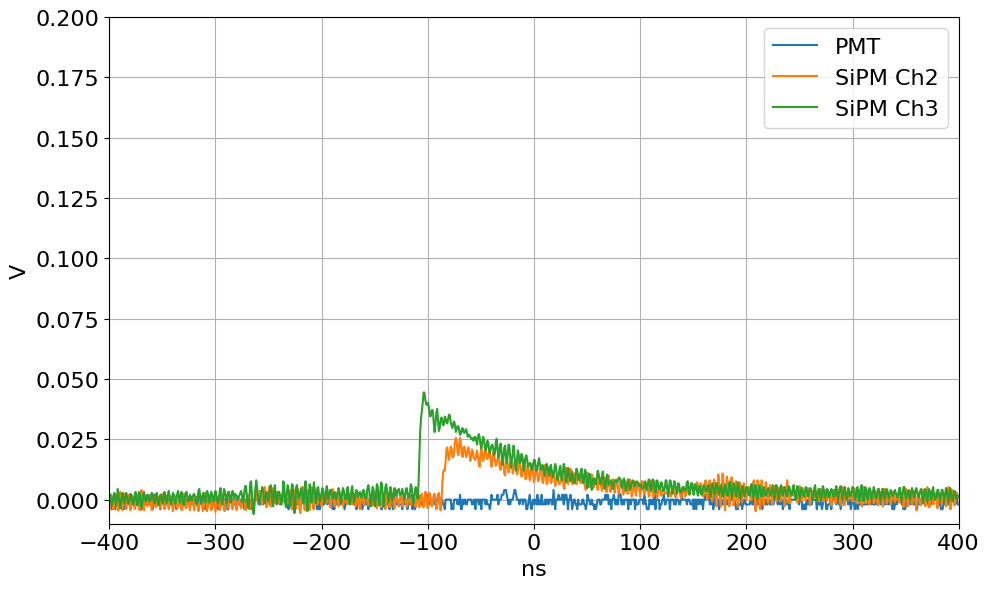

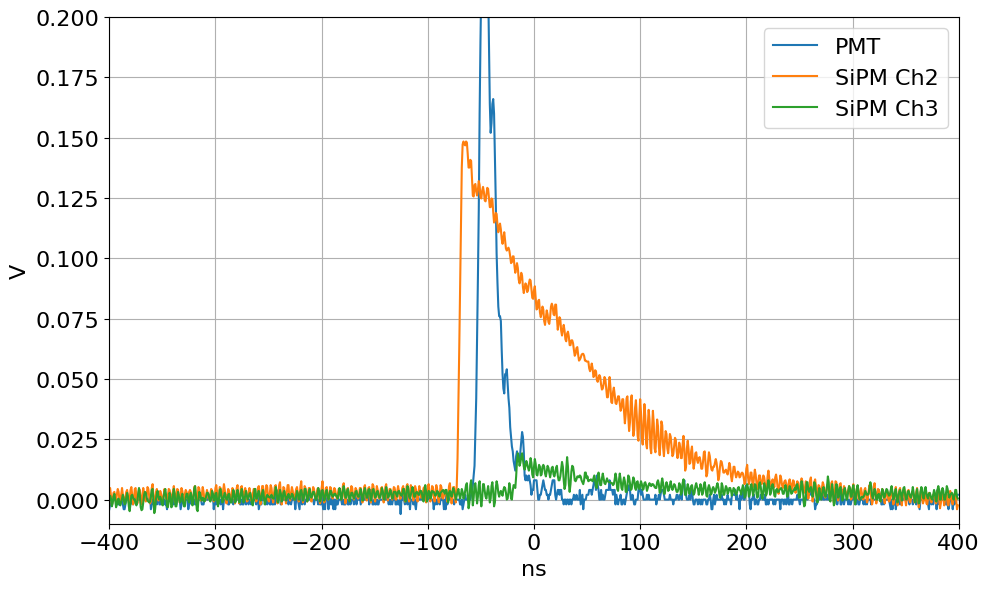

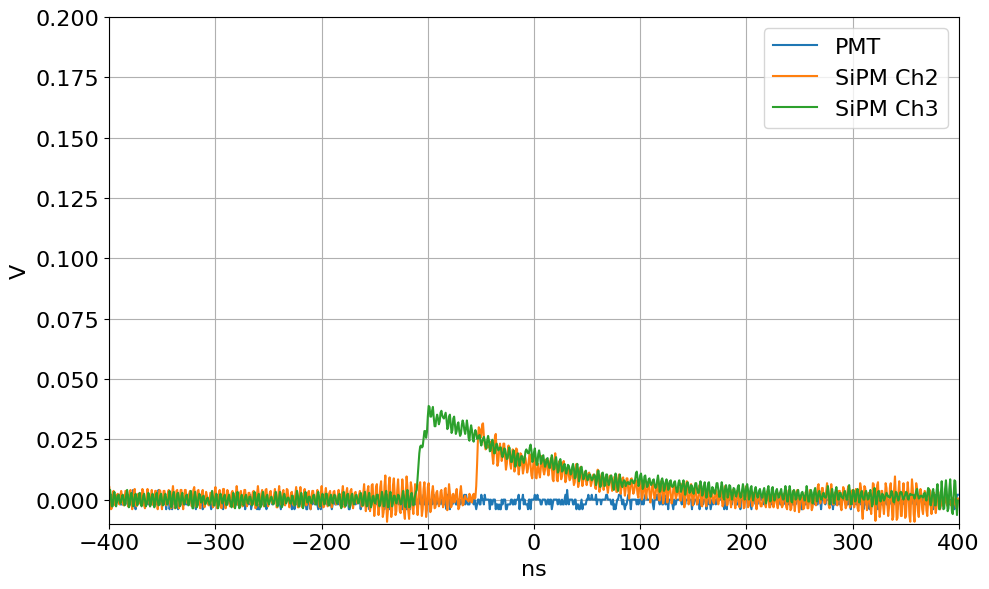

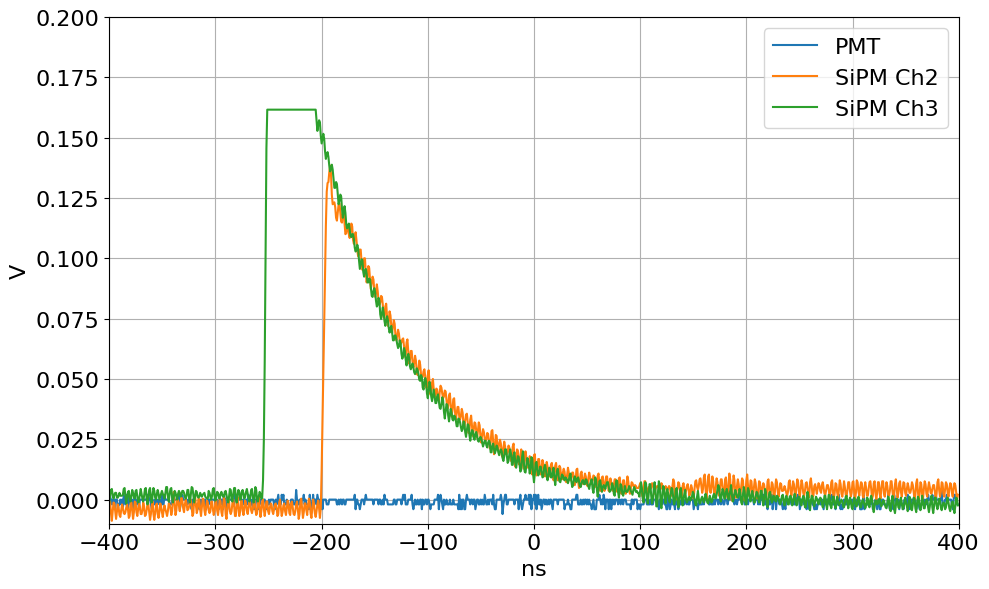

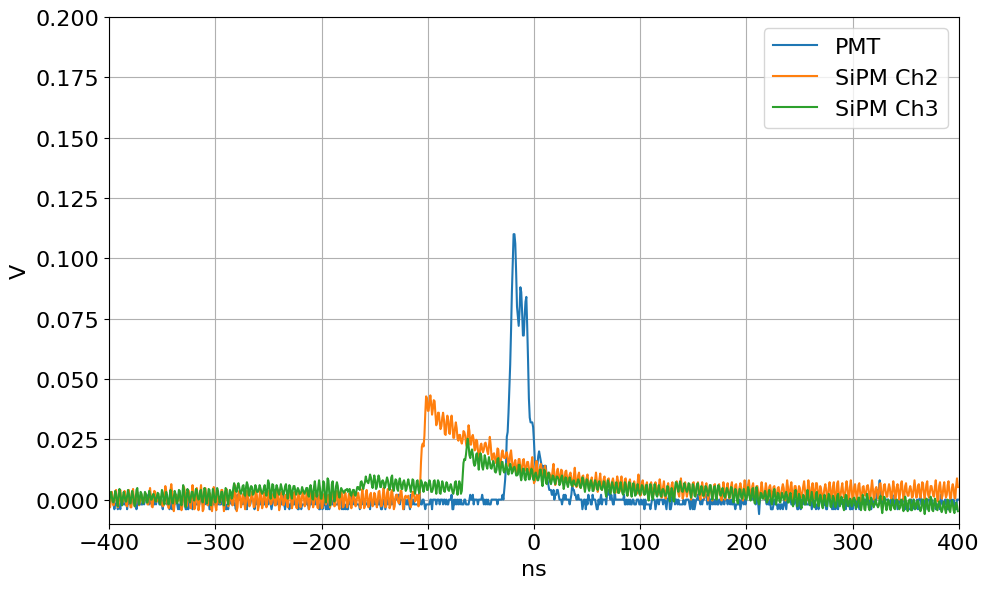

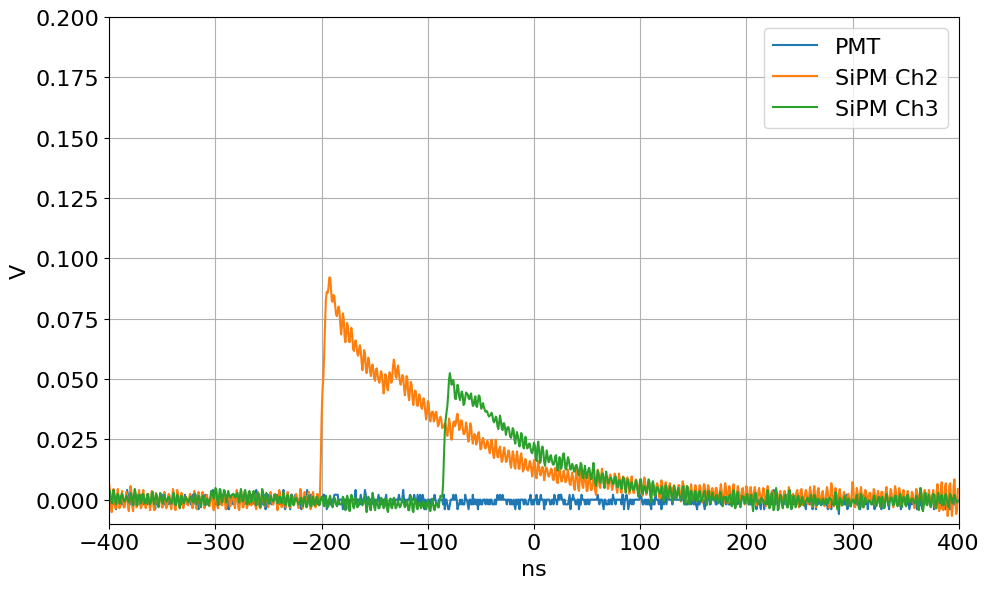

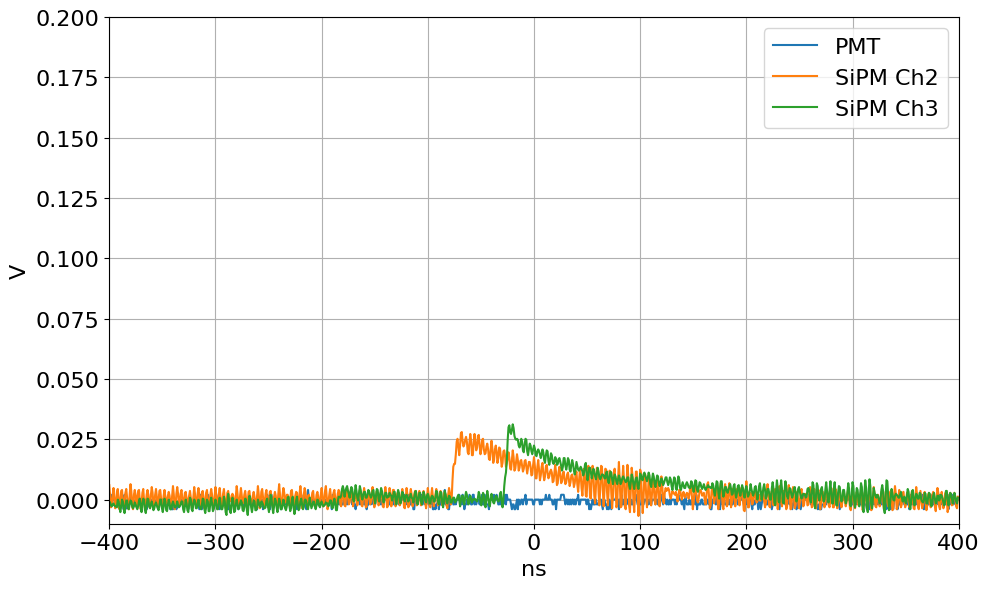

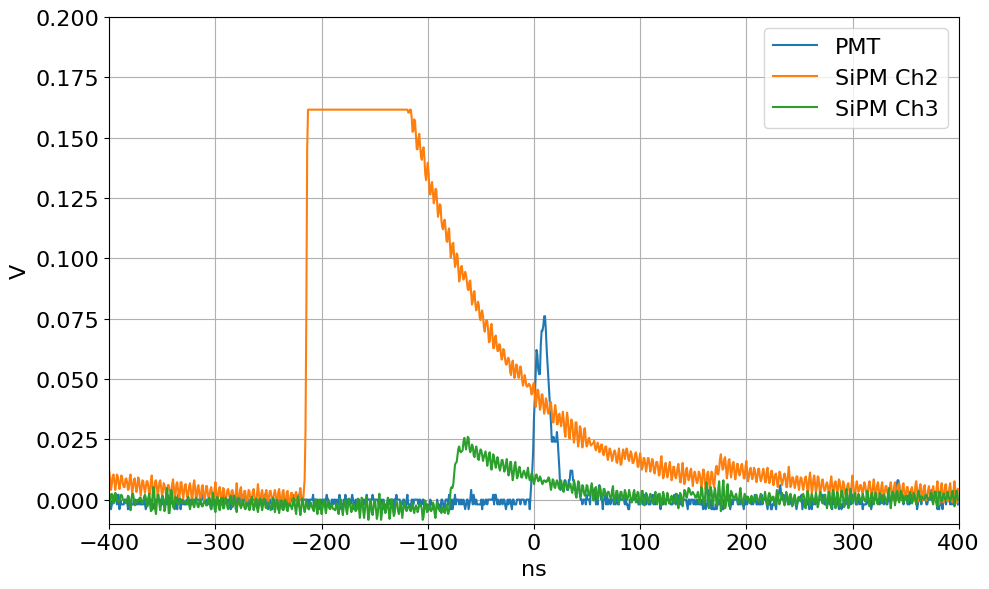

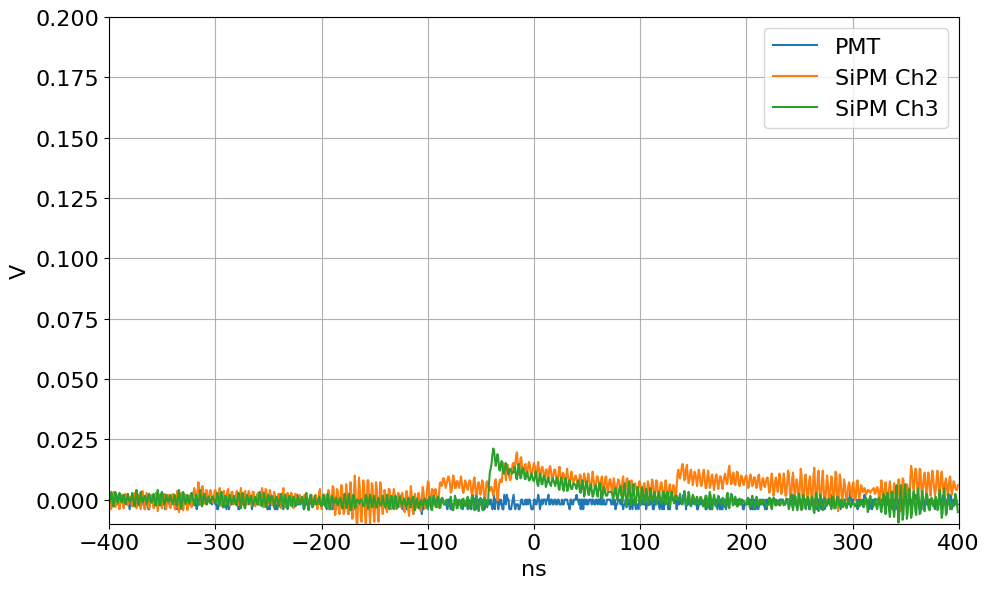

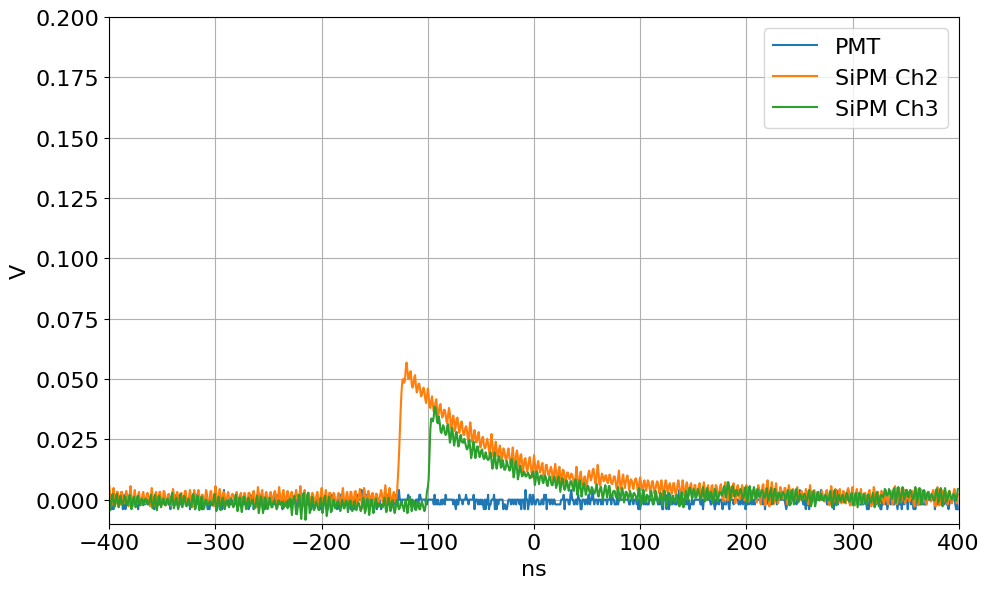

In [48]:
filepath = "./data/24-03-18_run-008_Ru106_Vthres-40mV_Ntrace-10000.npy"
#data = parseData(np.load(filepath))
data = np.load(filepath)
x_zero = -400
x_inc = 0.8
time = np.array([(x_zero +  t*x_inc) for t in range(1000)])

selected = np.random.choice(len(data), 10, replace=False)
print(selected)
#selected = [301]
for pulse in np.array(data)[selected]:
#for pulse in data:
    #pmtpulse, sipmpulse = findpulse(pulse, 0.04)
    plt.figure()
    plt.plot(time, pulse[0], label="PMT")
    plt.plot(time, pulse[1], label="SiPM Ch2")
    plt.plot(time, pulse[2], label="SiPM Ch3")
    #plt.plot(time, smoothpulse(pulse[0])/100, label="trig")
    plt.xlim(-400,400)
    plt.xlabel('ns')
    plt.ylim(-0.01,0.2)
    plt.ylabel('V')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()
    #print(pmtpulse,sipmpulse)

*** Finding coincidence for Sr-90, triggering on PMT... ***
Overall Rate: 21.63 Hz
Triple coincidence rate: 57.64 % (12.467532 Hz)
Triple coincidence rate (high E beta): 1.4000000000000001 % (0.30282 Hz)
SiPM coincidence rate: 57.65 %
- - - - -
*** Finding coincidence for Sr-90, triggering on SiPM... ***
Overall Rate: 369.19 Hz
Triple coincidence rate: 3.282 % (12.116815800000001 Hz)
Triple coincidence rate (high E beta): 0.062 % (0.2288978 Hz)
SiPM coincidence rate: 97.014 %
- - - - -
*** Finding coincidence for Ru-106, triggering on PMT... ***
Overall Rate: 49.91 Hz
Triple coincidence rate: 39.33 % (19.629603 Hz)
Triple coincidence rate (high E beta): 6.76 % (3.3739159999999995 Hz)
SiPM coincidence rate: 39.35 %
- - - - -
*** Finding coincidence for Ru-106, triggering on SiPM... ***
Overall Rate: 277.83 Hz
Triple coincidence rate: 8.155999999999999 % (22.659814799999996 Hz)
Triple coincidence rate (high E beta): 1.844 % (5.1231852 Hz)
SiPM coincidence rate: 93.99 %
- - - - -


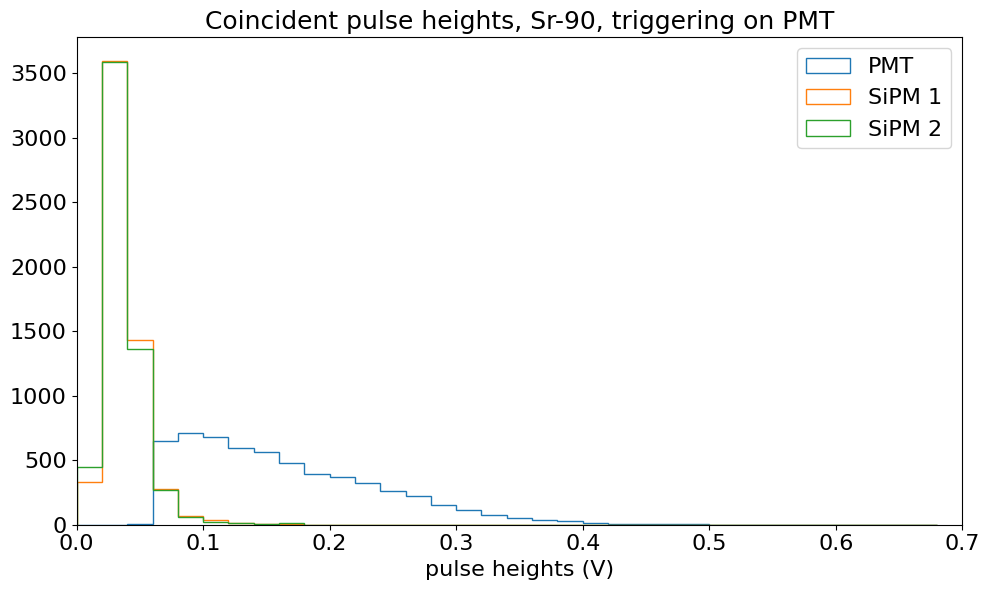

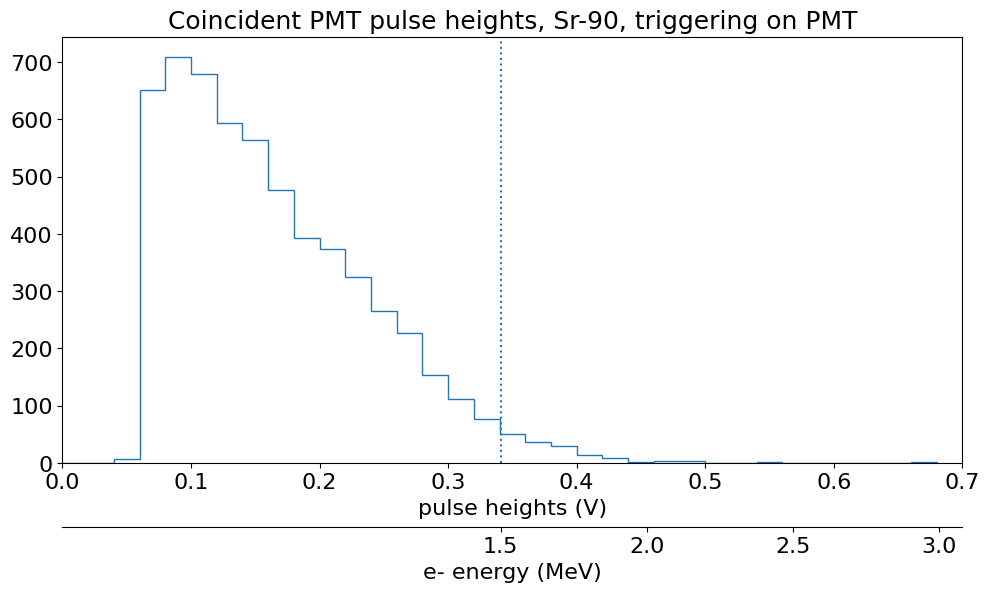

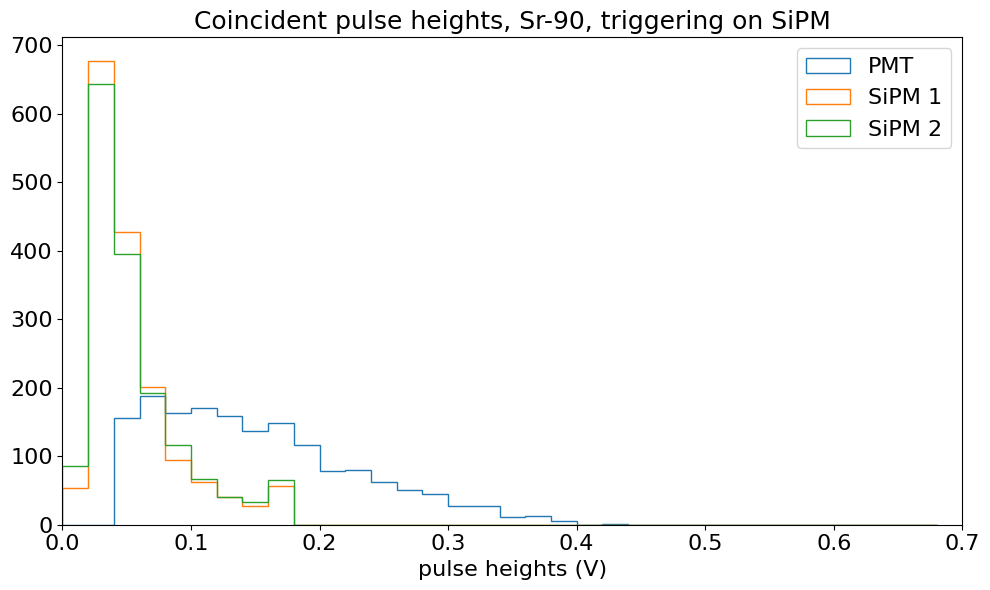

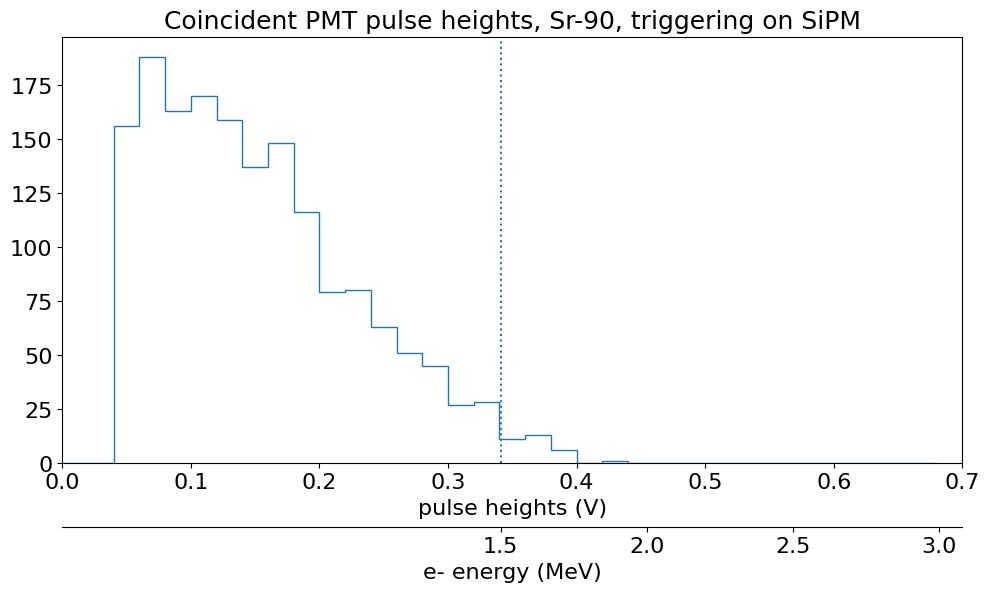

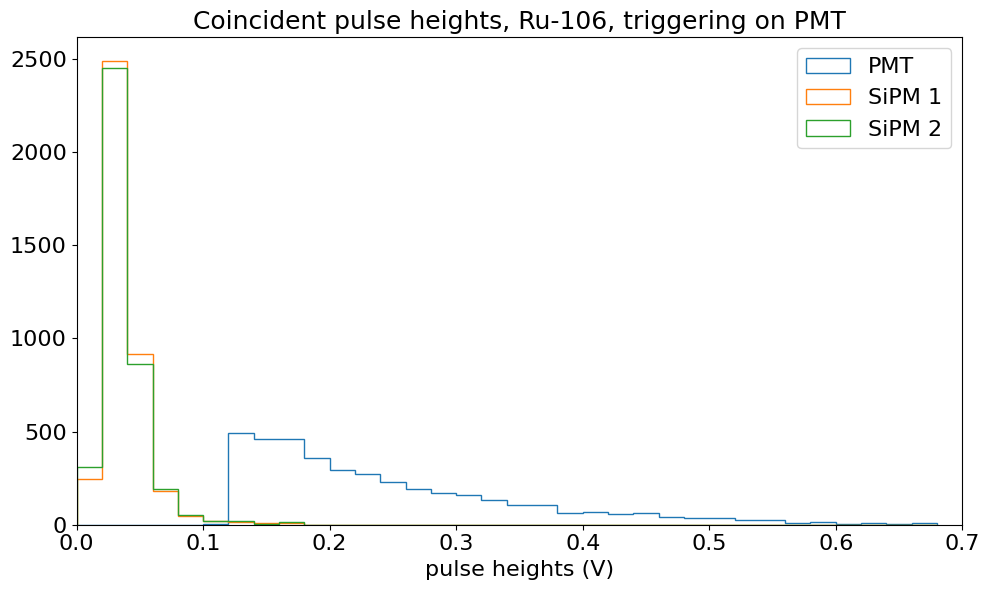

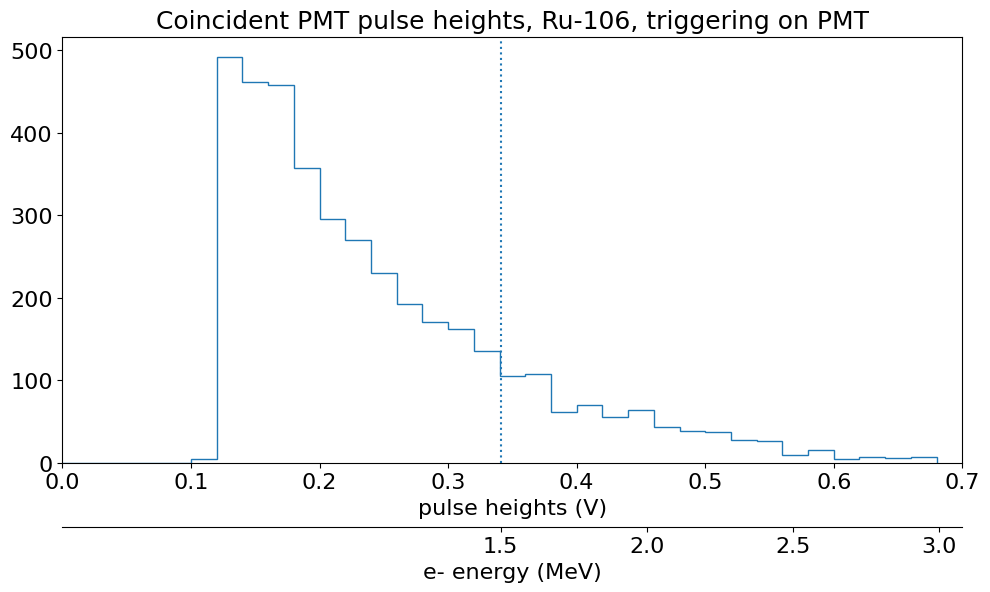

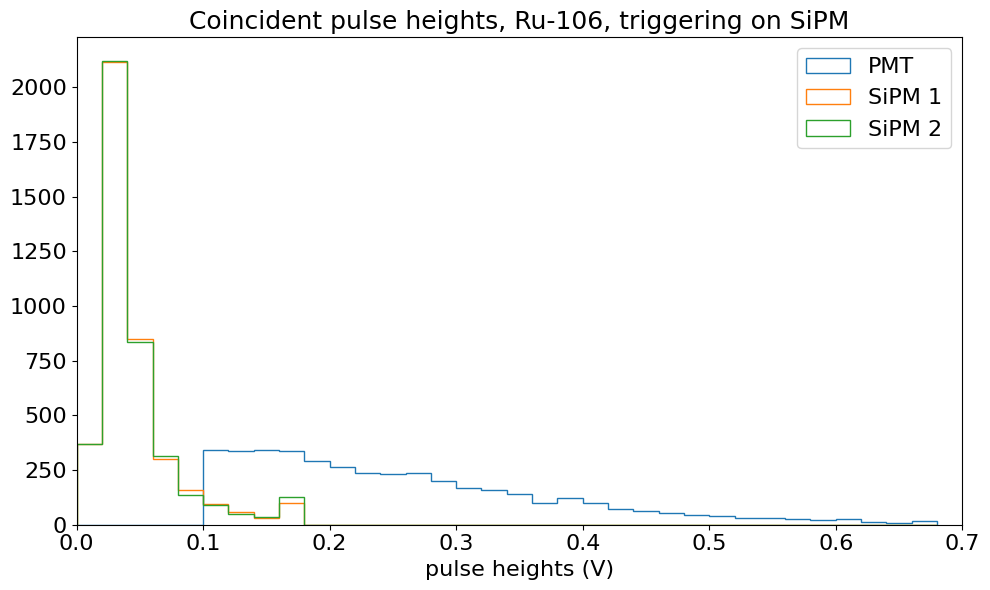

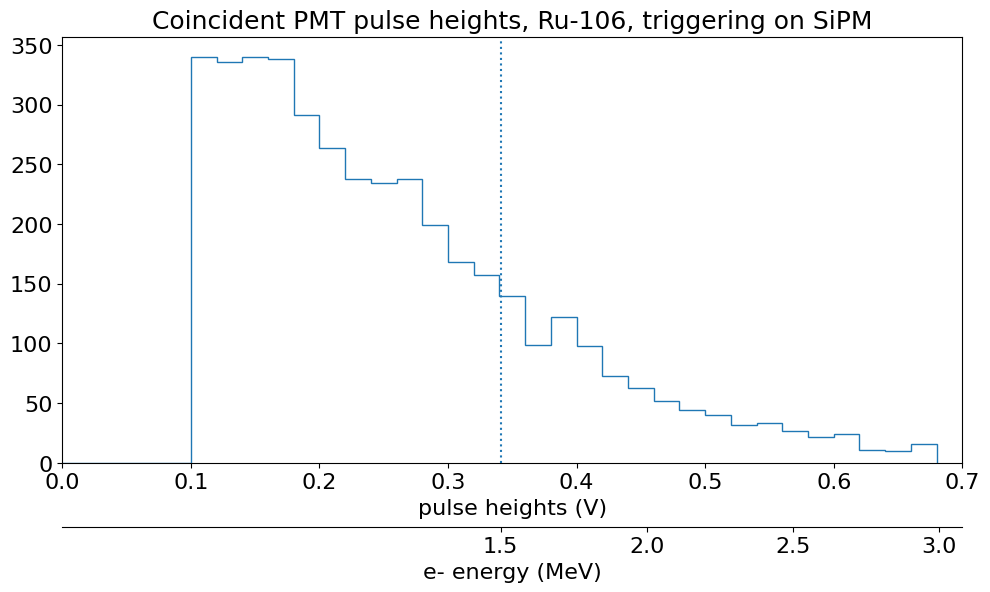

In [4]:
analysis("Sr-90, triggering on PMT", 0.04, 21.63,
         ["./data/24-03-18_run-005_Sr90_Vthres-40mV_Ntrace-10000.npy"])
analysis("Sr-90, triggering on SiPM", 0.04, 369.19,
         ["./data/24-03-18_run-000_Sr90_Vthres-10mV_Ntrace-10000.npy",
          "./data/24-03-18_run-001_Sr90_Vthres-10mV_Ntrace-10000.npy",
          "./data/24-03-18_run-002_Sr90_Vthres-10mV_Ntrace-10000.npy",
          "./data/24-03-18_run-003_Sr90_Vthres-10mV_Ntrace-10000.npy",
          "./data/24-03-18_run-004_Sr90_Vthres-10mV_Ntrace-10000.npy"])
analysis("Ru-106, triggering on PMT", 0.1, 49.91,
         ["./data/24-03-18_run-010_Ru106_Vthres-100mV_Ntrace-10000.npy"])
analysis("Ru-106, triggering on SiPM", 0.1, 277.83,
         ["./data/24-03-17_run-002_Ru106_Vthres-10mV_Ntrace-10000.npy",
          "./data/24-03-17_run-003_Ru106_Vthres-10mV_Ntrace-10000.npy",
          "./data/24-03-17_run-004_Ru106_Vthres-10mV_Ntrace-10000.npy",
          "./data/24-03-17_run-005_Ru106_Vthres-10mV_Ntrace-10000.npy",
          "./data/24-03-17_run-006_Ru106_Vthres-10mV_Ntrace-10000.npy",
         ])